In [1]:
import pandas as pd
# get data into np arrays
df = pd.read_csv("data/training_data.csv")
df = pd.get_dummies(df, columns=['stance'])
df['label'] = df[['stance_unrelated','stance_agree','stance_disagree','stance_discuss']].values.tolist()
df['label'] = df['label'].apply(lambda x: x.index(1))
df = df.sample(frac=1)

In [2]:
# grab np values
headlines = df['head'].values
bodies = df['body'].values
labels = df['label'].values

In [3]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Loading BERT tokenizer...


In [4]:
import torch
# tokenization
input_ids = []
attention_masks = []

for i in range(len(headlines)):
    encoded_dict = tokenizer.encode(
                        text=headlines[i],                      # headline to encode.
                        text_pair=bodies[i],
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,
                        pad_to_max_length=True,   # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.   
    #input_ids.append(encoded_dict['input_ids'])
    input_ids.append(encoded_dict)
    
    # And its attention mask (simply differentiates padding from non-padding).
    #attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
#attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', headlines[0], bodies[0])
print('Token IDs:', input_ids[0])

Original:  Is the iPhone 6 Really Pulling Out Your Hair? Fear not arachnophobes, the story of Bunbury's "spiderman" might not be all it seemed.

Perth scientists have cast doubt over claims that a spider burrowed into a man's body during his first trip to Bali. The story went global on Thursday, generating hundreds of stories online.

Earlier this month, Dylan Thomas headed to the holiday island and sought medical help after experiencing "a really burning sensation like a searing feeling" in his abdomen.

Dylan Thomas says he had a spider crawl underneath his skin.

Thomas said a specialist dermatologist was called in and later used tweezers to remove what was believed to be a "tropical spider".

But it seems we may have all been caught in a web... of misinformation.

Arachnologist Dr Volker Framenau said whatever the creature was, it was "almost impossible" for the culprit to have been a spider.

"If you look at a spider, the fangs, the mouth parts they have, they are not able to burr

In [5]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

44,974 training samples
4,998 validation samples


In [6]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [7]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [9]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [10]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 12

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [11]:
import numpy as np

# Function to calculate fnc score and max fnc score
def fnc_score(preds, labels):
    y_pred = np.argmax(preds, axis=1).flatten()
    y_true = labels.flatten()

    # compute max_score = 0.25*unrelated + (agree+disagree+discuss)
    total_count = torch.tensor(len(y_true))
    unrelated_count = torch.sum(y_true == 0)
    related_count = total_count - unrelated_count
    max_score = 0.25 * unrelated_count + related_count

    # compute score
    unrelated_pred = y_pred == 0
    unrelated_true = y_true == 0
    correct_unrelated_count = torch.sum(unrelated_pred & unrelated_true)
    correct_unrelated_count_score = 0.25 * correct_unrelated_count

    is_related_mask = ~unrelated_pred
    is_correct_mask = y_true == y_pred

    combined_mask_correct_related = is_related_mask & is_correct_mask
    correct_related_count = torch.sum(combined_mask_correct_related)
    correct_related_count_score = 1.0 * correct_related_count

    is_related_true_mask = ~unrelated_true
    combined_mask_related = is_related_mask & is_related_true_mask
    combined_mask_incorrect_related = combined_mask_related & ~combined_mask_correct_related
    incorrect_related_count = torch.sum(combined_mask_incorrect_related)
    incorrect_related_count_score = 0.25 * incorrect_related_count

    score = correct_unrelated_count_score + correct_related_count_score + incorrect_related_count_score
    return score, max_score

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return torch.sum(pred_flat == labels_flat).double() / len(labels_flat)

In [12]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [13]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('Using GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Using GPU: TITAN Xp


In [14]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 1 batches.
        if step % 1 == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        #b_input_mask = batch[1].to(device)
        b_labels = batch[1].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(input_ids=b_input_ids,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_fnc_score = 0
    total_eval_max_fnc_score = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        #b_input_mask = batch[1].to(device)
        b_labels = batch[1].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu()
        label_ids = b_labels.to('cpu')

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        # Calculate FNC score, max FNC score for this batch, and accumulate
        b_fnc_score, b_max_fnc_score = fnc_score(logits, label_ids)
        total_eval_fnc_score += b_fnc_score
        total_eval_max_fnc_score += b_max_fnc_score

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    # Report fnc scores over validation run
    relative_score = total_eval_fnc_score / total_eval_max_fnc_score
    print("  FNC Score: {0:.2f}".format(total_eval_fnc_score))
    print("  Maximum Possible FNC Score: {0:.2f}".format(total_eval_max_fnc_score))
    print("  Relative FNC Score: {0:.2f}".format(total_eval_fnc_score / total_eval_max_fnc_score))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time,
            'Valid. FNC Score': total_eval_fnc_score,
            'Valid. Max FNC Score': total_eval_max_fnc_score,
            'Relative FNC Score': relative_score
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 12 ========
Training...
  Batch     0  of  1,406.    Elapsed: 0:00:00.


/opt/conda/conda-bld/pytorch_1587428094786/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch     1  of  1,406.    Elapsed: 0:00:01.
  Batch     2  of  1,406.    Elapsed: 0:00:01.
  Batch     3  of  1,406.    Elapsed: 0:00:01.
  Batch     4  of  1,406.    Elapsed: 0:00:02.
  Batch     5  of  1,406.    Elapsed: 0:00:02.
  Batch     6  of  1,406.    Elapsed: 0:00:02.
  Batch     7  of  1,406.    Elapsed: 0:00:02.
  Batch     8  of  1,406.    Elapsed: 0:00:03.
  Batch     9  of  1,406.    Elapsed: 0:00:03.
  Batch    10  of  1,406.    Elapsed: 0:00:03.
  Batch    11  of  1,406.    Elapsed: 0:00:04.
  Batch    12  of  1,406.    Elapsed: 0:00:04.
  Batch    13  of  1,406.    Elapsed: 0:00:04.
  Batch    14  of  1,406.    Elapsed: 0:00:05.
  Batch    15  of  1,406.    Elapsed: 0:00:05.
  Batch    16  of  1,406.    Elapsed: 0:00:05.
  Batch    17  of  1,406.    Elapsed: 0:00:06.
  Batch    18  of  1,406.    Elapsed: 0:00:06.
  Batch    19  of  1,406.    Elapsed: 0:00:06.
  Batch    20  of  1,406.    Elapsed: 0:00:07.
  Batch    21  of  1,406.    Elapsed: 0:00:07.
  Batch    22

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Batch   369  of  1,406.    Elapsed: 0:02:03.
  Batch   370  of  1,406.    Elapsed: 0:02:03.
  Batch   371  of  1,406.    Elapsed: 0:02:03.
  Batch   372  of  1,406.    Elapsed: 0:02:04.
  Batch   373  of  1,406.    Elapsed: 0:02:04.
  Batch   374  of  1,406.    Elapsed: 0:02:04.
  Batch   375  of  1,406.    Elapsed: 0:02:05.
  Batch   376  of  1,406.    Elapsed: 0:02:05.
  Batch   377  of  1,406.    Elapsed: 0:02:05.
  Batch   378  of  1,406.    Elapsed: 0:02:06.
  Batch   379  of  1,406.    Elapsed: 0:02:06.
  Batch   380  of  1,406.    Elapsed: 0:02:06.
  Batch   381  of  1,406.    Elapsed: 0:02:07.
  Batch   382  of  1,406.    Elapsed: 0:02:07.
  Batch   383  of  1,406.    Elapsed: 0:02:07.
  Batch   384  of  1,406.    Elapsed: 0:02:08.
  Batch   385  of  1,406.    Elapsed: 0:02:08.
  Batch   386  of  1,406.    Elapsed: 0:02:08.
  Batch   387  of  1,406.    Elapsed: 0:02:09.
  Batch   388  of  1,406.    Elapsed: 0:02:09.
  Batch   389  of  1,406.    Elapsed: 0:02:09.
  Batch   390

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.24790016317986494,
  'Valid. Loss': 0.1080904268766427,
  'Valid. Accur.': tensor(0.9620, dtype=torch.float64),
  'Training Time': '0:07:50',
  'Validation Time': '0:00:16',
  'Valid. FNC Score': tensor(2107.7500),
  'Valid. Max FNC Score': tensor(2250.),
  'Relative FNC Score': tensor(0.9368)},
 {'epoch': 2,
  'Training Loss': 0.08422887178500889,
  'Valid. Loss': 0.0847216107963012,
  'Valid. Accur.': tensor(0.9767, dtype=torch.float64),
  'Training Time': '0:07:49',
  'Validation Time': '0:00:16',
  'Valid. FNC Score': tensor(2162.5000),
  'Valid. Max FNC Score': tensor(2250.),
  'Relative FNC Score': tensor(0.9611)},
 {'epoch': 3,
  'Training Loss': 0.04046000401104587,
  'Valid. Loss': 0.057625928122526524,
  'Valid. Accur.': tensor(0.9859, dtype=torch.float64),
  'Training Time': '0:07:48',
  'Validation Time': '0:00:16',
  'Valid. FNC Score': tensor(2197.5000),
  'Valid. Max FNC Score': tensor(2250.),
  'Relative FNC Score': tensor(0.9767)},
 {

In [30]:
!pip install matplotlib

     |████████████████████████████████| 12.4 MB 14.7 MB/s eta 0:00:01    |██████▌                         | 2.5 MB 14.7 MB/s eta 0:00:01     |███████████████████████▍        | 9.1 MB 14.7 MB/s eta 0:00:01
     |████████████████████████████████| 92 kB 25 kB/s s eta 0:00:01
     |████████████████████████████████| 67 kB 1.7 MB/s  eta 0:00:01


In [31]:
import matplotlib.pyplot as plt

In [34]:
epoch_numbers = [x['epoch'] for x in training_stats]
training_losses = [x['Training Loss'] for x in training_stats]
validation_losses = [x['Valid. Loss'] for x in training_stats]

<ipython-input-39-a2eb077b92e5>:3: UserWarning: The handle 'o' has a label of '_' which cannot be automatically added to the legend.
  plt.legend('training_loss', 'validation_loss')
<ipython-input-39-a2eb077b92e5>:3: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('training_loss', 'validation_loss')
<ipython-input-39-a2eb077b92e5>:3: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('training_loss', 'validation_loss')
<ipython-input-39-a2eb077b92e5>:3: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-lege

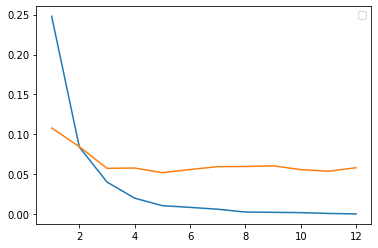

In [39]:
plt.plot(epoch_numbers, training_losses)
plt.plot(epoch_numbers, validation_losses)
plt.legend('training_loss', 'validation_loss')